Percolation & Coffee Extraction Simulation by Will Janes

Written for the Physics of Espresso group project.

The Site class:

Parameters:
- Site.empty: bool. Dictates whether the site is empty (True) or contains water/coffee (False). Cause almost all other parameters to be ignored if True.
- Site.water: bool. Dictates whether a site is water (True) or coffee (False).
- Site.coffee: int. Stores how much soluble coffee is present in the cell.
- Site.insoluble: bool. Dictates whether a coffee site is turned empty upon its coffee parameter reaching 0 (True if so). Represents insolubles that remain in place (for the purposes of the model) during percolation.
- Site.absorption, Site.deposition, Site.transfer, Site.insolubility: floats. Read in various event probabilities (described in detail in the Percolation class documentation). Should be given values from 0 to 1, though values outside this range will not return an error (merely act as 0 or 1 depending on if they are <0 or  >1 respectively)
- Site.saturation, Site.maxCoffee: ints. Read in the Percolation.saturation parameters.

Methods:
- Site.setToCoffee(int newCoffee): Initialises the Site as a coffee site with a soluble coffee parameter equal to newCoffee and an insolubility determined randomly based on the corresponding simulation parameter.
- Site.moveToSite(Site site): Copies this Site's water and coffee parameters to the target Site and sets this Site to empty.
- Site.absorptionStep(Site[] sitesAround): For every Site in sitesAround, a water site will attempt to absorb 1 coffee with a chance dictated by the absorption simulation parameter. Additionally, a coffee site will attempt to absorb 1 coffee from a water site in sitesAround, this time with a chance dictated by the deposition simulation parameter.
- Site.updateStep(): If this Site is not insoluble or water and has 0 coffee, it is set to empty. Additionally, if this site is empty and has coffee greater than 0, its coffee is set to 0.
- Site.movementStep(Site[] targetSites): If this Site is a water Site, attempts to move (via Site.moveToSite) to first the Site below and, failing that, either neighbour. It is assumed that the chance of a water Site moving upwards is 0. The movement has a probability dictated by the transfer simulation parameter.
- Site.scoreStep(): Sets the Site to empty and outputs its coffee content. Used to count extracted coffee.
- Site.generateStep(): If this Site is empty, becomes water. Used to create new water Sites at the top of the puck.

The Percolation class:

Parameters:
- Percolation.size: tuple of ints, format (Number of columns, Number of rows). Dictates the size of the lattice of Sites.
- Percolation.density: float. Chance that a Site will be initialised as a coffee Site. A higher value will lead to a greater proportion of coffee compared to empty.
- Percolation.tMax: int. Number of iterations over which to run the simulation.
- Percolation.absorption: float. Chance that a water Site will successfully absorb from a neighbouring Site on a given absorption attempt (NOT over the course of an entire absorption step, as this will be rolled at most four times per Site in that case). A higher value means more chance for a given absorption to succeed.
- Percolation.deposition: float. Chance that a coffee Site will successfully absorb from a neighbouring water Site on a given deposition attempt. A higher value means more chance for a given deposition to succeed.
- Percolation.transfer: float: Chance that a water Site will attempt to move at all on a given movement step. A higher value means more chance for water Sites to successfully move.
- Percolation.insolubility: float. Chance that a coffee Site will be initialised as insoluble. A higher value means more chance for a coffee Site to be insoluble. Note that setting this to a relatively high value dramatically increases that chance of no path existing through the puck especially for small lattice dimensions.
- Percolation.saturation: int. Maximum soluble coffee that a water Site can contain. If a water Site's coffee is equal to the Percolation.saturation parameter, it will no longer attempt to absorb.
- Percolation.maxCoffee: int. Maximum soluble coffee that a coffee Site can be initialised with. In addition, if a coffee Site's coffee is equal to the Percolation.maxCoffee parameter, it will no longer attempt to receive coffee via deposition.
- Percolation.seed: (any type). Value used to seed the random number generator. Defaults to None, resulting in the RNG using the system time as normal for the python random library.

Methods:
- Percolation.simulate(int tTest=-1): Runs the simulation, logging the state after 1, tTest and Percolation.tMax iterations. A grid of Sites is generated and initialised with a coffee distribution created randomly based on the simulation parameters. The top row of the grid is emptied and then filled with water, creating the initial state. For t from 0 to tMax, the Site.absorptionStep(), Site.updateStep(), and Site.movementStep() (or Site.scoreStep() if the Site is at the bottom of the puck) methods are run for each Site in turn, before the score and time are logged, new water is generated in any empty Sites at the top of the puck, and the process is repeated.
- Percolation.plotState(Site[] state): Generates and shows a graphical visualisation of the puck in the given state.
- Percolation.output(bool visualisation=True): Calls Percolation.plotState() for the initial, target and final states, and also generates and displays a plot of the % coffee extracted (i.e. (score / initial coffee) * 100) against number of iterations. The extraction data is also analysed to determine the initial coffee present, final coffee extracted total, time of optimal extraction, and time of 100% extraction (if that was reached), with the values being printed below the plots. If only the analysis is desired, the visualisations and extraction% vs time plot can be disabled by setting the visualisation argument to False.

In [1]:
import random as r
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
class Site:
    def __init__(self, empty, water, coffee, insoluble, absorption, deposition, transfer, insolubility, saturation, maxCoffee):
        self.empty = empty #dictates whether this cell is empty
        self.water = water #dictates whether this cell is water or coffee (True for water)
        self.coffee = coffee #dictates how much coffee is present in this cell
        self.insoluble = insoluble #dictates whether the coffee cell cannot be converted to empty on running out of coffee
        self.absorption = absorption #chance of absorbing a coffee from an adjacent cell
        self.deposition = deposition
        self.transfer = transfer #chance of attempting to execute a move
        self.insolubility = insolubility #chance of an new coffee cell being insoluble
        self.saturation = saturation #max coffee before no longer being able to absorb
        self.maxCoffee = maxCoffee
        
        if self.coffee == 0 and self.water == False and self.empty == False:
            self.empty = True
            
    def setToCoffee(self,newCoffee):
        self.empty = False
        self.water = False
        self.coffee = newCoffee
        if r.random() < self.insolubility:
            self.insoluble = True
        return self.coffee
            
    def moveToSite(self,site):
        site.empty = False
        site.water = True
        site.coffee = self.coffee
        self.empty = True
            
    def absorptionStep(self, sitesAround):
        if self.water == True and self.empty == False:
            for site in sitesAround:
                if site != None and (not site.empty) and site.coffee > 0 and self.coffee < self.saturation:
                    if r.random() < self.absorption:
                        self.coffee += 1
                        site.coffee -= 1
        elif self.water == False and self.empty == False:
            for site in sitesAround:
                if site != None and (not site.empty) and (not site.water) and site.coffee > 0 and self.coffee < self.maxCoffee:
                    if r.random() < self.deposition:
                        self.coffee += 1
                        site.coffee -= 1
                        
    def updateStep(self):
        if self.water == False and self.empty == False and self.coffee == 0 and self.insoluble == False:
            self.empty = True
        
        if self.empty == True:
            self.coffee = 0
    
    def movementStep(self, targetSites):
        directionLR = r.random()
        if r.random() < self.transfer:
            transferAllowed = [True,True,True]
            for count in range(len(targetSites)):
                if targetSites[count] == None:
                    transferAllowed[count] = False
                elif targetSites[count].empty != True:
                    transferAllowed[count] = False
                
            if transferAllowed[0]:
                self.moveToSite(targetSites[0])
            elif ((directionLR <0.5 and transferAllowed[1] and transferAllowed[2]) or (transferAllowed[1] and not transferAllowed[2])):
                self.moveToSite(targetSites[1])
            elif ((directionLR >=0.5 and transferAllowed[1] and transferAllowed[2]) or (not transferAllowed[1] and transferAllowed[2])):
                self.moveToSite(targetSites[2])
                
    def scoreStep(self):
        scoreOut = self.coffee
        self.coffee = 0
        self.empty = True
        return scoreOut
                
    def generateStep(self):
        if self.empty == True:
            self.empty = False
            self.coffee = 0
            self.water = True

In [11]:
class Percolation:
    def __init__(self, size, density, tMax, absorption, deposition, transfer, insolubility, saturation, maxCoffee, seed=None):
        self.size = size
        self.density = density
        self.tMax = tMax
        self.absorption = absorption
        self.deposition = deposition
        self.transfer = transfer
        self.insolubility = insolubility
        self.saturation = saturation
        self.maxCoffee = maxCoffee
        self.seed = seed
        
    def simulate(self,tTest=-1):
        #initialise simulation
        r.seed(self.seed)
        self.initCoffee = 0
        self.score = 0
        
        self.initState = []
        self.targetState = []
        self.ts = []
        self.scores = []
        
        self.grid = np.zeros(self.size,Site)
        for i in range(0,self.grid.shape[0]):
            for j in range(0,self.grid.shape[1]):
                self.grid[i][j] = Site(True,False,0,False,self.absorption,self.deposition,self.transfer,self.insolubility,self.saturation,self.maxCoffee)
                
                #create initial coffee distribution and count initial coffee
                if i>0:
                    if r.random() < self.density:
                        self.initCoffee += self.grid[i][j].setToCoffee(r.randint(1,self.maxCoffee))
                    
        #create intial water along the top of the puck
        for j in range(0,self.grid.shape[1]):
            self.grid[0][j].generateStep()
            
        #set the target state to None if no tTest is provided
        if tTest<0:
            self.targetState=None
                    
        #main simulation loop
        for t in np.arange(0,self.tMax):
            #absorption step. every water attempts to absorb from neighbouring coffee, and vice-versa for deposition
            for i in range(0,self.grid.shape[0]):
                for j in range(0,self.grid.shape[1]):
                    sitesAround = []
                    iValues = [i-1,i+1,i,i]
                    jValues = [j,j,j-1,j+1]
                    for k in range(len(iValues)):
                        try:
                            sitesAround.append(self.grid[iValues[k]][jValues[k]])
                        except IndexError:
                            sitesAround.append(None)
                    self.grid[i][j].absorptionStep(sitesAround)
            
            #update step. coffee sites with no coffee are updated to empty and empty sites are cleared of coffee
            for i in range(0,self.grid.shape[0]):
                for j in range(0,self.grid.shape[1]):
                    self.grid[i][j].updateStep()
                    
            #movement step. water sites attempt to move to neighbouring empty sites
            for i in reversed(list(range(0,self.grid.shape[0]))):
                for j in reversed(list(range(0,self.grid.shape[1]))):
                    if self.grid[i][j].water == True and self.grid[i][j].empty == False:
                        targetSites = []
                        iValues = [i+1,i,i]
                        jValues = [j,j-1,j+1]
                        for k in range(len(iValues)):
                            try:
                                targetSites.append(self.grid[iValues[k]][jValues[k]])
                            except:
                                targetSites.append(None)
                            
                        if targetSites[0] == None:
                            self.score += self.grid[i][j].scoreStep()
                        else:
                            self.grid[i][j].movementStep(targetSites)
                        
            #score is logged to output array
            self.ts.append(t)
            self.scores.append(self.score)
                        
            #generation step. new water sites are created at empty spots in the top row
            for j in range(0,self.grid.shape[1]-1):
                if self.grid[0][j].empty == True:
                    self.grid[0][j].generateStep()
            
            #at display timesteps, log simulation state
            if t==0:
                self.initState = copy.deepcopy(self.grid)
            if t==tTest:
                self.targetState = copy.deepcopy(self.grid)
    
    def plotState(self,state):
        xs = range(0,state.shape[1])
        ys = range(0,state.shape[0])
        X, Y = np.meshgrid(xs,ys)
        
        plt.figure(figsize=(9,5))
        plt.scatter(X,Y, c="white")
        plt.xlabel("j")
        plt.ylabel("i")
        plt.ylim(np.max(Y)+1,-1)
        for i in range(0,state.shape[0]):
            for j in range(0,state.shape[1]):
                if state[i][j].empty == True:
                    plt.text(j, i, str(state[i][j].coffee), color="white", fontsize=12)
                elif state[i][j].water == True:
                    plt.text(j, i, str(state[i][j].coffee), color="blue", fontsize=12)
                elif state[i][j].insoluble == True:
                    plt.text(j, i, str(state[i][j].coffee), color="maroon", fontsize=12)
                else:
                    plt.text(j, i, str(state[i][j].coffee), color="sandybrown", fontsize=12)
        plt.show()
    
    def output(self, visualisation=True):
        if visualisation:
            self.plotState(self.initState)
            if np.array(self.targetState).all() != None:
                self.plotState(self.targetState)
            self.plotState(self.grid)
        
        self.scoresPercentage = np.dot(np.divide(np.array(self.scores),self.initCoffee),100).tolist()
        
        if visualisation:
            plt.plot(self.ts, self.scoresPercentage)
            plt.xlabel("Time")
            plt.ylabel("% of Coffee Extracted")
            plt.show()
        
        #find optimal extraction point to display
        #for a visualisation of the optimal point (e.g. to see if channeling has occured), run the simulation once with no target state and again with target state equal to optimal t
        try:
            optimals = [x for x in self.scoresPercentage if round(x) in range(19,23)]
            optimalt = self.ts[self.scoresPercentage.index(optimals[int(len(optimals)/2)])]
        except IndexError:
            optimalt=None
            
        #find maximum extraction point, i.e. 100% extraction
        try:
            maxs = [x for x in self.scoresPercentage if round(x)>=100]
            maxt = self.ts[self.scoresPercentage.index(maxs[0])]
        except IndexError:
            maxt=None
        
        print("Initial Coffee: " + str(self.initCoffee))
        print("Coffee Extracted: " + str(self.score))
        if optimalt != None:
            print("Optimal Extraction at time: " + str(optimalt) + " (" + str(optimals[int(len(optimals)/2)]) + "%)")
        else:
            print("Optimal extraction never achieved. Either extraction occurs too quickly around the optimal extraction point, or optimal extraction threshold is never reached at all.")
        if maxt != None:
            print("100% Extraction at time: " + str(maxt))
        else:
            print("Maximum extraction never achieved. Highest % of coffee extracted: " + str(np.max(np.array(self.scoresPercentage))) + "%")

To run the simulation, a Percolation class should be initialised with the simulation parameters specified. The Percolation.simulate() and Percolation.output() methods should then be run in that order. To obtain a visualisation of the puck at optimal extraction, these methods should then be run again, but the tTest argument of Percolation.simulation() should be set to the time of optimal extraction printed by the initial run (rather than left as the default). If a second run is intended, setting the visualisation argument of Percolation.output() to False for the initial run may be desired for presentation and to save processing time.

Below is an example, run with some reasonable parameters:

In [15]:
#initialise simulation
percolation = Percolation(size=(10,30),density=0.6,tMax=300,absorption=0.3,deposition=0.05,transfer=0.9,insolubility=0.3,saturation=15,maxCoffee=9,seed=502)
#perform initial run without visualisation to obtain optimal time
percolation.simulate()
percolation.output(visualisation=False)

Initial Coffee: 782
Coffee Extracted: 770
Optimal Extraction at time: 40 (20.20460358056266%)
Maximum extraction never achieved. Highest % of coffee extracted: 98.46547314578005%


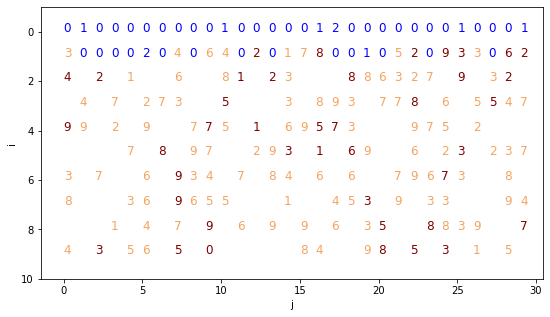

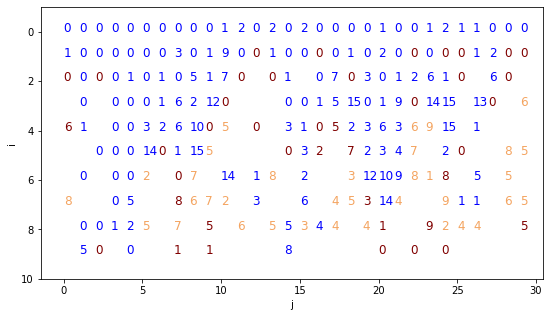

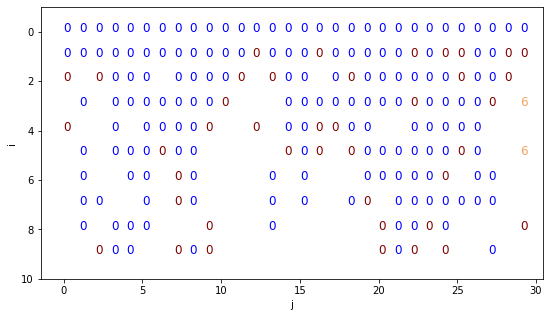

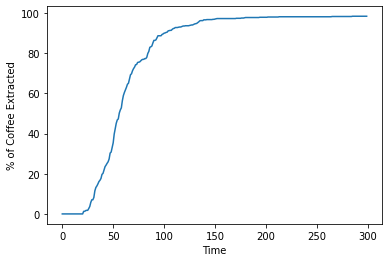

Initial Coffee: 782
Coffee Extracted: 770
Optimal Extraction at time: 40 (20.20460358056266%)
Maximum extraction never achieved. Highest % of coffee extracted: 98.46547314578005%


In [16]:
#run with visualisation & optimal time to obtain desired output
percolation.simulate(40)
percolation.output()